<a href="https://colab.research.google.com/github/rohitraj29/pb_client/blob/main/FashionCLIP_Feature_Extraction_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Hands-On Tutorial on FashionCLIP

Welcome to our FashionCLIP tutorial! Here we will show how you can embed your own images with FashionCLIP and play with the representations.

[![Youtube Video](https://img.shields.io/badge/youtube-video-red)](https://www.youtube.com/watch?v=uqRSc-KSA1Y)
[![HuggingFace Model](https://img.shields.io/badge/HF%20Model-Weights-yellow)](https://huggingface.co/spaces/clip-italian/clip-italian-demo)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1Z1hAxBnWjF76bEi9KQ6CMBBEmI_FVDrW?usp=sharing)
[![Medium Blog Post](https://raw.githubusercontent.com/aleen42/badges/master/src/medium.svg)](https://towardsdatascience.com/teaching-clip-some-fashion-3005ac3fdcc3)


**VERY IMPORTANT** \
If your collection of images is large, make sure you are using a **GPU** (if you are on Colab go to Runtime -> Change Runtime Type). Otherwise it's going to take long to compute embeddings!


### Use Cases

We will go through three different possible usages of FashionCLIP:

*   **Image Retrieval.** Given a query, we will find the image that best describe that query.

*   **Zero Shot Classification.** Given an image, we will try to classify some images using some labels.

*   **Feature Extraction for Supervised Learning.** We will extract image features using FashionCLIP and use them to do image classification.

## Getting Started

To start this tutorial, let's first download some images!

In [1]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

The dataset we used is a sample that comes from [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).  We report here data access and use found on Kaggle.

**A. Data Access and Use.**

Competition Use and Non-Commercial & Academic Research: You may access and use the Competition Data for non-commercial purposes only, including for participating in the Competition and on Kaggle.com forums, and for academic research and education. The Competition Sponsor reserves the right to disqualify any participant who uses the Competition Data other than as permitted by the Competition Website and these Rules.

### The FashionCLIP Model

We wrote a simple wrapper that allows you to play with the data a bit and do most of the things you might want to do with few lines of code!

It should take 2/3 minutes to install.

In [ ]:
%%capture
!pip install -U fashion-clip

In [ ]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

Let's now FashionCLIP first. It's going to take a couple of minutes to download the model from the HuggingFace Hub.

In [ ]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, as CLIP, creates a shared vector space for images and text. This allows us to tackle many tasks, such as retrieval (find the image that is most similar to a given query) or zero shot classification (find which lables fit an image best).

There are basically two main components, and image encoder (to generate a vector starting from an image) and a text encoder (to generate a vector startinf from a piece of text). The general concept is summarized in the following GIF (in 2D).



<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



First thing first, let's load the data!
Also, let's drop some elements to simplify the analysis.

In [ ]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# drop items that have the same description
subset = articles.drop_duplicates("detail_desc").copy()

# remove items of unkown category
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# FashionCLIP has a limit of 77 tokens, let's play it safe and drop things with more than 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# We also drop products types that do not occur very frequently in this subset of data
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

# lots of data here, but we will just use only descriptions and a couple of other columns
subset.head(3)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,176754003,176754,2 Row Braided Headband (1),74,Hair/alice band,Accessories,1010016,Solid,17,Yellowish Brown,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Two-strand hairband with braids in imitation s...
3,189634031,189634,Long Leg Leggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,93,Dark Green,...,Basic 1,D,Divided,2,Divided,51,Divided Basics,1002,Jersey Basic,Leggings in stretch jersey with an elasticated...


In [ ]:
subset.to_csv("subset_data.csv", index=False)
f"There are {len(subset)} elements in the dataset"

'There are 3104 elements in the dataset'

## Image Retrieval

How do we do retrieval?

We encode a search query (e.g., "A red dress") with FashionCLIP text encoder and retrieve the closest image vectors through a simple dot product. The greater the value of the dot product, the more similar the text and the image are.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


Ok now let's get all the images and all the captions, generate embeddings and then normalize the embeddings to unit norm.

In [ ]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# we create image embeddings and text embeddings
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

# we normalize the embeddings to unit norm (so that we can use dot product instead of cosine similarity to do comparisons)
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings/np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

100%|██████████| 97/97 [03:50<00:00,  2.37s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:07<00:00, 13.22it/s]


Let's write a quick function to see how well our retrieval works! We are going to compute **precision@5**.

In [ ]:
precision = 0

# we could batch this operation to make it faster
for index, t in enumerate(text_embeddings):
    arr = t.dot(image_embeddings.T)

    best = arr.argsort()[-5:][::-1]

    if index in best:
        precision +=1

round(precision/len(text_embeddings), 2)

0.54

Good! **0.54** on this completely unseen dataset is honestly a pretty good result! It means that more than half of the times, the product we are looking for is in the top 5 returned items.

### Building a Toy Search Engine

Let's now test our toy "product search engine". We will embed a textual query and then rank the images we have by similarity with the query vector.



Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 50.95it/s]


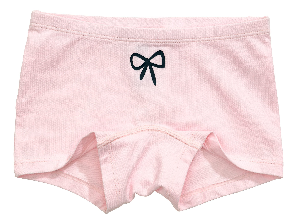

In [ ]:
text_embedding = fclip.encode_text(["a pair of pink shorts"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

Note that, if the query does not make sense - in this context - the model is not going to return anything useful.

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 40.65it/s]


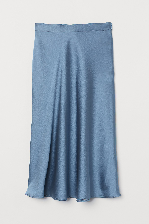

In [ ]:
text_embedding = fclip.encode_text(["a house"], 32)[0]

id_of_matched_object = np.argmax(text_embedding.dot(image_embeddings.T))
found_object = subset["article_id"].iloc[id_of_matched_object].tolist()

fixed_height = 224

image = Image.open(f"data_for_fashion_clip/{found_object}.jpg")
height_percent = (fixed_height / float(image.size[1]))
width_size = int((float(image.size[0]) * float(height_percent)))
image = image.resize((width_size, fixed_height), Image.NEAREST)

image

# Zero Shot Classification

ZeroShot classification is one of the most exciting applications of CLIP like models! We encode the image of a fashion item we want to classify with FashionCLIP’s image encoder and retrieve the closest label vectors through a dot product.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



In [ ]:
labels = subset["product_type_name"].unique()
print(f"These are our labels: {labels}")

These are our labels: ['Vest top' 'Hair/alice band' 'Leggings/Tights' 'T-shirt' 'Sneakers'
 'Sunglasses' 'Cardigan' 'Gloves' 'Underwear Tights' 'Hoodie' 'Other shoe'
 'Shorts' 'Jumpsuit/Playsuit' 'Dress' 'Trousers' 'Belt' 'Socks'
 'Underwear bottom' 'Bodysuit' 'Hat/beanie' 'Scarf' 'Jacket'
 'Other accessories' 'Bra' 'Swimwear bottom' 'Blazer' 'Top' 'Polo shirt'
 'Sweater' 'Necklace' 'Pyjama set' 'Blouse' 'Bag' 'Shirt' 'Coat' 'Boots'
 'Skirt' 'Garment Set' 'Bikini top' 'Sandals' 'Dungarees' 'Earring'
 'Cap/peaked' 'Ballerinas' 'Swimsuit' 'Hat/brim']


In [ ]:
labels_prompt = [f"a photo of a {k}" for k in labels]

label_embeddings = fclip.encode_text(labels_prompt, batch_size=32)
label_embeddings = label_embeddings/np.linalg.norm(label_embeddings, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

2it [00:00, 11.02it/s]                       


In [ ]:
# let's compute the class distribution for all images
predicted_classes_distribution = label_embeddings.dot(image_embeddings.T)

In [ ]:
# let's take the best label (the most similar to the image)
predicted = [labels[k] for k in np.argmax(predicted_classes_distribution, axis=0)]

In [ ]:
print(classification_report(subset["product_type_name"], predicted))

                   precision    recall  f1-score   support

              Bag       0.97      0.88      0.92        40
       Ballerinas       0.67      0.15      0.25        13
             Belt       0.80      0.92      0.86        13
       Bikini top       0.68      0.73      0.70        37
           Blazer       0.94      0.84      0.89        38
           Blouse       0.47      0.79      0.59       135
         Bodysuit       0.53      0.64      0.58        25
            Boots       0.91      0.65      0.75        31
              Bra       0.90      0.77      0.83        60
       Cap/peaked       0.95      0.86      0.90        21
         Cardigan       0.58      0.86      0.69        49
             Coat       0.17      0.92      0.29        12
            Dress       0.92      0.77      0.84       293
        Dungarees       0.32      0.67      0.43        12
          Earring       0.98      0.84      0.90        55
      Garment Set       0.71      0.18      0.29       

Results look good! **0.69** in Macro F1 on many classes **without the need of training anything**!!

There are a couple of classes in which we don't do well, for example **Top** and it might be because in English it's an ambigous term.

Moreover, I haven't actually searched for a prompt that works well and some of the classes contain a "\" in the name that might complicate the prediction.

Anyway, considering that we did this without studying the data much, we got a pretty good performance!

# Feature Extraction for Supervised Learning

Finally, let's do some classification with the image features we have extracted before. We will use the features to train a linear classifier and see how it performs!



In [ ]:
classes = subset["product_group_name"].tolist()
X_train, X_test, y_train, y_test = train_test_split(image_embeddings, classes, test_size=0.20, random_state=32, stratify=classes)

In [ ]:
clf = LogisticRegression(random_state=0, class_weight="balanced").fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

                    precision    recall  f1-score   support

       Accessories       0.86      1.00      0.92        65
 Garment Full body       0.69      0.95      0.80        73
Garment Lower body       0.98      0.94      0.96       131
Garment Upper body       1.00      0.85      0.92       258
         Nightwear       0.58      1.00      0.74         7
             Shoes       1.00      0.90      0.95        30
    Socks & Tights       0.75      0.90      0.82        10
          Swimwear       0.65      0.68      0.67        19
         Underwear       0.96      0.96      0.96        28

          accuracy                           0.90       621
         macro avg       0.83      0.91      0.86       621
      weighted avg       0.92      0.90      0.91       621



We slightly under perform on Nightwear, but probably because we don't have much data. But the classifier works really well!


Note: If you do this with **product_type_name** you are going to get a Macro F1 0.86 (that is better than the zero-shot one!).

### Visualizing Image Embeddings in the Latent Space

To address our use cases, we assume FashionCLIP embeds images in the latent space following an underlying semantics. Let's use a dimensionality reduction algorithm to visualize that.

UMAP is a well-known dimension reduction algorithm that works out-of-the-box on multidimensional data. Through UMAP, we can remap our image embeddings into a 2D space and plot it as a scatterplot.

In [ ]:
!pip install umap-learn

import umap

reducer = umap.UMAP()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
umap_embeddings = reducer.fit_transform(image_embeddings)

In [ ]:
# shape: (number of images, 2)
umap_embeddings.shape

In [ ]:
umap.plot.points(reducer, labels=np.array(classes))

UMAP reduction highlights interesting things:
- distinct fashion categories cluster in distinct regions of the space;
- shoes, accessories, socks & tights are well separated from garnments images.